In [1]:
from typing import Union

import google.cloud.aiplatform as vertex_ai
import pandas as pd
from google.cloud import bigquery

In [2]:
bq_client = bigquery.Client()

In [3]:
# Wrapper to use BigQuery client to run query/job, return job ID or result as DF
def run_bq_query(sql: str) -> Union[str, pd.DataFrame]:
    """
    Input: SQL query, as a string, to execute in BigQuery
    Returns the query results as a pandas DataFrame, or error, if any
    """

    # Try dry run before executing query to catch any errors
    job_config = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False)
    bq_client.query(sql, job_config=job_config)

    # If dry run succeeds without errors, proceed to run query
    job_config = bigquery.QueryJobConfig()
    client_result = bq_client.query(sql, job_config=job_config)

    job_id = client_result.job_id

    # Wait for query/job to finish running. then get & return data frame
    df = client_result.result().to_arrow().to_pandas()
    print(f"Finished job_id: {job_id}")
    return df

In [4]:
sql_query = """
SELECT users.user_id, profiles.name, profiles.username,
profiles.public_metrics.followers_count, 
profiles.public_metrics.following_count,
users.non_irony,
users.not_hate,
users.not_offensive,
users.avg_dense_model_score,
users.avg_lstm_score,
users.not_real

 FROM `fake-news-bears.hot_off_the_press.congress_profiles` profiles
 JOIN `fake-news-bears.hot_off_the_press.users_scores_combined` users
 ON profiles.id = CAST(users.user_id AS INT)
"""

my_df = run_bq_query(sql_query)

Finished job_id: 06cd1e5e-4222-4d93-a3d7-03a3a66699e1


In [5]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                423 non-null    object 
 1   name                   423 non-null    object 
 2   username               423 non-null    object 
 3   followers_count        423 non-null    int64  
 4   following_count        423 non-null    int64  
 5   non_irony              423 non-null    object 
 6   not_hate               423 non-null    object 
 7   not_offensive          423 non-null    object 
 8   avg_dense_model_score  423 non-null    float64
 9   avg_lstm_score         423 non-null    float64
 10  not_real               423 non-null    object 
dtypes: float64(2), int64(2), object(7)
memory usage: 36.5+ KB


In [6]:
my_df.head()

,user_id,name,username,followers_count,following_count,non_irony,not_hate,not_offensive,avg_dense_model_score,avg_lstm_score,not_real
0,2964877294,Rep. Mike Bost,RepBost,17329,1969,0.7482,0.9556,0.8884,0.604264,0.505773,0.99
1,1880674038,US Rep Kathy Castor,USRepKCastor,25181,5510,0.7337,0.9675,0.9001,0.630194,0.494619,0.9913
2,85396297,Rep. Joe Courtney,RepJoeCourtney,27011,2239,0.7017,0.9814,0.9223,0.580164,0.511706,0.9632
3,2970279814,Rep. Debbie Dingell,RepDebDingell,103518,2588,0.7237,0.9641,0.8768,0.751672,0.501941,0.9721
4,90639372,Congressman Dwight Evans,RepDwightEvans,20707,3534,0.6825,0.9691,0.9029,0.569151,0.457926,0.9936


In [8]:
# standard scaler
from sklearn.preprocessing import StandardScaler

In [16]:

cols = ['non_irony', 'not_hate', 'not_offensive', 'avg_dense_model_score', 'avg_lstm_score', 'not_real']
scaled_cols = ["scaled_" + i for i in cols]


scaler = StandardScaler()
my_df[scaled_cols] = scaler.fit_transform(my_df[cols])


In [17]:
my_df

,user_id,name,username,followers_count,following_count,non_irony,not_hate,not_offensive,avg_dense_model_score,avg_lstm_score,not_real,scaled_non_irony,scaled_not_hate,scaled_not_offensive,scaled_avg_dense_model_score,scaled_avg_lstm_score,scaled_not_real
0,2964877294,Rep. Mike Bost,RepBost,17329,1969,0.7482,0.9556,0.8884,0.604264,0.505773,0.99,0.646169,-0.470095,0.247509,-0.113143,0.273096,0.663866
1,1880674038,US Rep Kathy Castor,USRepKCastor,25181,5510,0.7337,0.9675,0.9001,0.630194,0.494619,0.9913,0.400555,0.260927,0.611458,0.186820,-0.455219,0.713494
2,85396297,Rep. Joe Courtney,RepJoeCourtney,27011,2239,0.7017,0.9814,0.9223,0.580164,0.511706,0.9632,-0.141490,1.114809,1.302030,-0.391926,0.660491,-0.359238
3,2970279814,Rep. Debbie Dingell,RepDebDingell,103518,2588,0.7237,0.9641,0.8768,0.751672,0.501941,0.9721,0.231166,0.052063,-0.113330,1.592088,0.022852,-0.019476
4,90639372,Congressman Dwight Evans,RepDwightEvans,20707,3534,0.6825,0.9691,0.9029,0.569151,0.457926,0.9936,-0.466717,0.359215,0.698558,-0.519330,-2.851011,0.801298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,389840566,Rep. Steven Horsford,RepHorsford,18629,2010,0.6423,0.9696,0.898,0.684235,0.507347,0.9749,-1.147660,0.389931,0.546134,0.811971,0.375827,0.087416
419,40302336,Rep. Nadler,RepJerryNadler,454827,2026,0.5789,0.9575,0.8396,0.689122,0.503553,0.978,-2.221586,-0.353377,-1.270504,0.868501,0.128117,0.205760
420,1051446626,Ann Wagner,RepAnnWagner,29072,2357,0.6254,0.9744,0.8506,0.579157,0.532458,0.9197,-1.433928,0.684797,-0.928329,-0.403580,2.015453,-2.019873
421,249410485,"Sanford Bishop, Jr.",SanfordBishop,26455,805,0.7639,0.982,0.9206,0.775268,0.504001,0.9562,0.912109,1.151668,1.249148,1.865049,0.157396,-0.626467


In [18]:
# clustering
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [19]:
df_feats = my_df[scaled_cols]

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_feats)
    distortions.append(kmeanModel.inertia_)

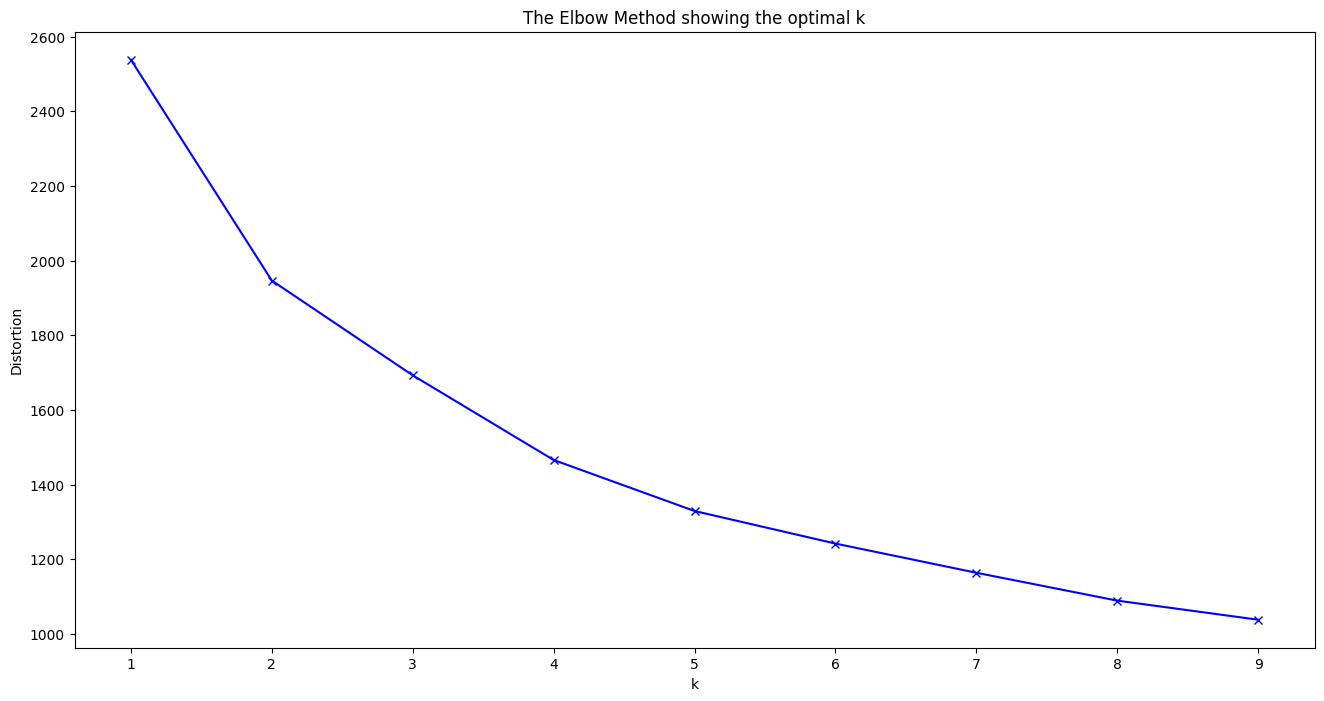

In [20]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [21]:
kmeanModel = KMeans(n_clusters=4)
kmeanModel.fit(df_feats)
my_df['cluster'] = kmeanModel.predict(df_feats)

In [25]:
my_df[['name','cluster']].head(10)

,name,cluster
0,Rep. Mike Bost,3
1,US Rep Kathy Castor,3
2,Rep. Joe Courtney,3
3,Rep. Debbie Dingell,3
4,Congressman Dwight Evans,0
5,Rep. Jared Huffman,0
6,Rep. Kevin Kiley,1
7,Rep. Doug Lamborn,2
8,Rep. Lucy McBath,3
9,Rep. Jay Obernolte,1


In [26]:
my_df[['name','cluster']].groupby(by=['cluster']).count()

,name
cluster,
0,107
1,36
2,116
3,164


In [32]:
# getting the least negative and most truthful people

# flip the signs of metrics so that postive = good, negative = bad

my_df['scaled_real'] = -my_df['scaled_not_real']
my_df['scaled_dense_pos'] = -my_df['scaled_avg_dense_model_score']
my_df['scaled_lstm_pos'] = -my_df['scaled_avg_lstm_score']

cols_ordered = ['scaled_non_irony', 'scaled_not_hate', 'scaled_not_offensive', 
                'scaled_real', 'scaled_dense_pos', 'scaled_lstm_pos']

my_df['scores_summed'] = my_df[cols_ordered].sum(axis=1)

In [35]:
my_df[['name', 'scores_summed']].sort_values(by=['scores_summed'], ascending=False)

,name,scores_summed
103,Congressman Bill Keating,10.999196
29,Rep. James Moylan,7.583618
235,Senator Todd Young,6.244427
6,Rep. Kevin Kiley,5.967117
38,RepMarkAmodei,5.965377
...,...,...
393,Hakeem Jeffries,-8.242457
95,Rep. Darrell Issa,-8.996800
142,Rep. Guy Reschenthaler,-9.095549
340,Brian Babin,-9.633789
